In [21]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

In [22]:
fp='output/tif/NDVI.tif'
out_tif='output.tif'

In [23]:
data = rasterio.open(fp)

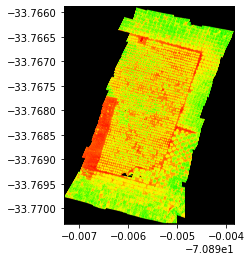

In [50]:
show((data, [1,2,3]), cmap='terrain')

In [25]:
import shapefile
sf = shapefile.Reader("output/shp/T2 P8.kmz.shp")
print(sf.shapeType)
print(sf.bbox) #longitud, latitud, longitud, latitud



15
[-70.89630767619413, -33.76819279061475, -70.89613303959966, -33.76800204342464]


In [26]:
minx, miny = sf.bbox[0], sf.bbox[1]
maxx, maxy = sf.bbox[2], sf.bbox[3]
bbox = box(minx, miny, maxx, maxy)

In [27]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))


In [28]:
geo = geo.to_crs(crs=data.crs.data)

In [29]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [30]:
coords = getFeatures(geo)

In [31]:
print(coords)

[{'type': 'Polygon', 'coordinates': [[[-70.89613303959966, -33.76819279061475], [-70.89613303959966, -33.76800204342464], [-70.89630767619413, -33.76800204342464], [-70.89630767619413, -33.76819279061475], [-70.89613303959966, -33.76819279061475]]]}]


In [34]:
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [35]:
out_meta = data.meta.copy()

In [36]:
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6600, 'height': 8431, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.267371250802094e-07, 0.0, -70.89730939002408,
       0.0, -5.267371250802094e-07, -33.7658764560272)}


In [37]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

4326


In [39]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

In [40]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
    

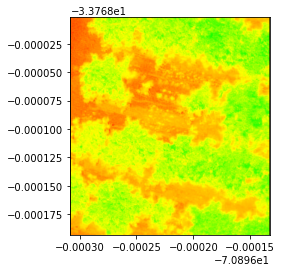

In [51]:
clipped = rasterio.open(out_tif)
show((clipped, [1,2,3]), cmap='terrain')